In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [16]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [17]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [18]:
percTrain = 70
percVal = 20 

In [19]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [20]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 24
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [21]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [22]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)



<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [23]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "dilation rate =" , dilation_rate , "kernel size =" , kernel_size , )
        return log , dilation_rate , kernel_size

getLayers( 2 , 24 , 3)

layers = 4 dilation rate = 2 kernel size = 3


(4, 2, 3)

<Strong> First 4-Layer Model with <i> dilation_rate = 2 </i> and <i> kernel_size = 3 </i> </Strong>

In [24]:
def createModelFourLayers(hp):
    
    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])
    hp_dropout = hp.Choice ('dropout' , values = [0.0 , 0.05 , 0.1])

    
    model = models.Sequential()
    
    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=2))
    model.add(Conv1D(filters= hp_filters , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=4))
    model.add(Conv1D(filters= hp_filters , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=8))
    
    model.add(Flatten())
    
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model

In [25]:
tuner = RandomSearch (
    createModelFourLayers,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn 4 layers 24 window'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 24, 8)             32        
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 8)             200       
                                                                 
 conv1d_6 (Conv1D)           (None, 24, 8)             200       
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 8)             200       
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [26]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 22 Complete [00h 02m 31s]
val_loss: 0.0008894348284229636

Best val_loss So Far: 0.0005284466897137463
Total elapsed time: 00h 41m 53s

Search: Running Trial #23

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.006             |0.006             
dense_layer       |16                |64                
filters           |32                |16                
dropout           |0.1               |0                 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            3104      
                                                               

KeyboardInterrupt: 

In [40]:
tuner.results_summary()

Results summary
Results in tcn/tcn_layers_learningrate
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 16
Score: 0.0005253675626590848
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 32
Score: 0.000525396375451237
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 16
Score: 0.0005256770527921617
Trial summary
Hyperparameters:
learning_rate: 0.006
dense_layer: 64
filters: 16
Score: 0.0005272998823784292
Trial summary
Hyperparameters:
learning_rate: 0.006
dense_layer: 16
filters: 16
Score: 0.0005352931329980493
Trial summary
Hyperparameters:
learning_rate: 0.008
dense_layer: 16
filters: 32
Score: 0.000537893851287663
Trial summary
Hyperparameters:
learning_rate: 0.008
dense_layer: 16
filters: 8
Score: 0.0005382135859690607
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 64
filters: 32
Score: 0.0005399492802098393
Trial sum

<Strong> Creating model and graphing results from tuner search. </Strong>

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 120, 16)           64        
                                                                 
 conv1d_33 (Conv1D)          (None, 120, 16)           784       
                                                                 
 conv1d_34 (Conv1D)          (None, 120, 16)           784       
                                                                 
 conv1d_35 (Conv1D)          (None, 120, 16)           784       
                                                                 
 flatten_8 (Flatten)         (None, 1920)              0         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense_16 (Dense)            (None, 32)               

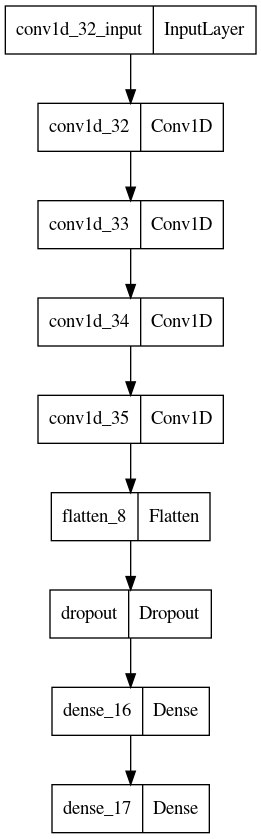

In [65]:

model = models.Sequential()

model.add(Conv1D(filters= 16, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 16, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=2))
model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=4))
model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=8))

model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model))
    
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt , loss = 'mse')




In [66]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 3s 47ms/step - loss: 0.0065 - val_loss: 0.0224
Epoch 2/300
54/54 [==============================] - 2s 45ms/step - loss: 9.4513e-04 - val_loss: 0.0246
Epoch 3/300
54/54 [==============================] - 2s 44ms/step - loss: 6.6041e-04 - val_loss: 0.0276
Epoch 4/300
54/54 [==============================] - 2s 44ms/step - loss: 4.6725e-04 - val_loss: 0.0209
Epoch 5/300
54/54 [==============================] - 2s 44ms/step - loss: 3.4119e-04 - val_loss: 0.0286
Epoch 6/300
54/54 [==============================] - 2s 44ms/step - loss: 2.9088e-04 - val_loss: 0.0068
Epoch 7/300
54/54 [==============================] - 2s 44ms/step - loss: 2.6704e-04 - val_loss: 0.0073
Epoch 8/300
54/54 [==============================] - 2s 44ms/step - loss: 2.0802e-04 - val_loss: 0.0031
Epoch 9/300
54/54 [==============================] - 2s 44ms/step - loss: 2.1191e-04 - val_loss: 0.0067
Epoch 10/300
54/54 [==============================] - 2s 45ms/step -

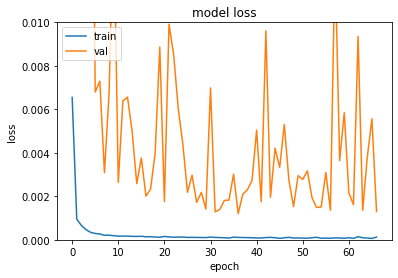

In [69]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()


<Strong> Second 4-Layer Model with <i> dilation_rate = 2 </i> and <i> kernel_size = 4 </i> </Strong>

In [119]:
def createModelFourLayerSecond(hp):
    
    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])
    hp_dropout = hp.Choice ('dropout' , values = [0.0 , 0.05 , 0.1])

    
    model = models.Sequential()
    
    model.add(Conv1D(filters= hp_filters, kernel_size=4, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
    model.add(Conv1D(filters= hp_filters, kernel_size=4, activation='relu' , padding = 'causal', dilation_rate=2))
    model.add(Conv1D(filters= hp_filters , kernel_size=4, activation='relu' , padding = 'causal' , dilation_rate=4))
    model.add(Conv1D(filters= hp_filters , kernel_size=4, activation='relu' , padding = 'causal' , dilation_rate=8))
    
    model.add(Flatten())
    
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model

In [120]:
tuner = RandomSearch (
    createModelFourLayerSecond,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_4_layers_second_second'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 120, 8)            40        
                                                                 
 conv1d_5 (Conv1D)           (None, 120, 8)            264       
                                                                 
 conv1d_6 (Conv1D)           (None, 120, 8)            264       
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            264       
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 16)               

In [ ]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 18 Complete [00h 08m 56s]
val_loss: 0.0007492100703530014

Best val_loss So Far: 0.0005815059994347394
Total elapsed time: 01h 21m 34s

Search: Running Trial #19

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.004             |0.002             
dense_layer       |32                |32                
filters           |32                |32                
dropout           |0                 |0                 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           4128      
                                                               

In [51]:
tuner.results_summary()

Results summary
Results in tcn/tcn_4_layers_second
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 32
Score: 0.0005220960010774434
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 128
filters: 8
Score: 0.0005243536434136331
Trial summary
Hyperparameters:
learning_rate: 0.008
dense_layer: 16
filters: 32
Score: 0.0005306143430061638
Trial summary
Hyperparameters:
learning_rate: 0.006
dense_layer: 32
filters: 16
Score: 0.0005409209406934679
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 16
Score: 0.0005486105801537633
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 32
filters: 8
Score: 0.0005531273200176656
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 128
filters: 32
Score: 0.0005551068461500108
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 64
filters: 8
Score: 0.0005555329844355583
Trial summary

<Strong> Creating model and graphing results from tuner search. </Strong>

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 120, 32)           192       
                                                                 
 conv1d_37 (Conv1D)          (None, 120, 32)           5152      
                                                                 
 conv1d_38 (Conv1D)          (None, 120, 32)           5152      
                                                                 
 conv1d_39 (Conv1D)          (None, 120, 32)           5152      
                                                                 
 flatten_9 (Flatten)         (None, 3840)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3840)              0         
                                                                 
 dense_18 (Dense)            (None, 32)               

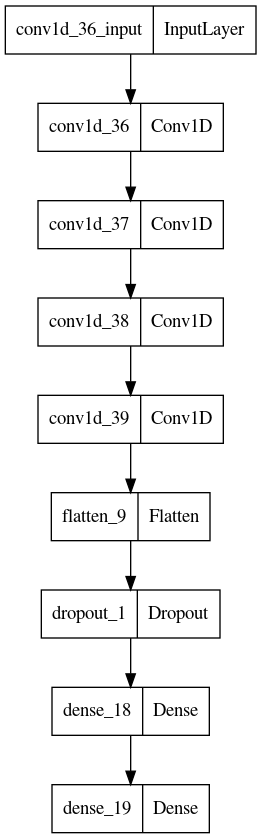

In [70]:

model = models.Sequential()

model.add(Conv1D(filters= 32, kernel_size=5, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 32, kernel_size=5, activation='relu' , padding = 'causal', dilation_rate=2))
model.add(Conv1D(filters= 32, kernel_size=5, activation='relu' , padding = 'causal' , dilation_rate=4))
model.add(Conv1D(filters= 32, kernel_size=5, activation='relu' , padding = 'causal' , dilation_rate=8))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model))
    
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt , loss = 'mse')



In [71]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 6s 100ms/step - loss: 0.0066 - val_loss: 0.0326
Epoch 2/300
54/54 [==============================] - 5s 99ms/step - loss: 0.0011 - val_loss: 0.0224
Epoch 3/300
54/54 [==============================] - 5s 97ms/step - loss: 7.9520e-04 - val_loss: 0.0110
Epoch 4/300
54/54 [==============================] - 5s 98ms/step - loss: 5.5463e-04 - val_loss: 0.0071
Epoch 5/300
54/54 [==============================] - 5s 98ms/step - loss: 4.4978e-04 - val_loss: 0.0071
Epoch 6/300
54/54 [==============================] - 5s 98ms/step - loss: 3.4663e-04 - val_loss: 0.0056
Epoch 7/300
54/54 [==============================] - 5s 97ms/step - loss: 3.4237e-04 - val_loss: 0.0067
Epoch 8/300
54/54 [==============================] - 5s 98ms/step - loss: 2.9083e-04 - val_loss: 0.0195
Epoch 9/300
54/54 [==============================] - 5s 98ms/step - loss: 2.6827e-04 - val_loss: 0.0039
Epoch 10/300
54/54 [==============================] - 5s 97ms/step - lo

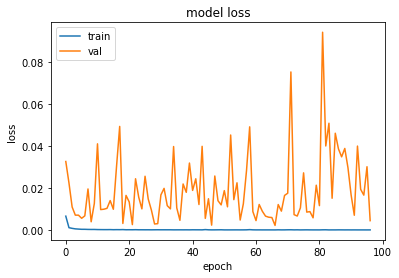

In [74]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()
